<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
!pip install timm
!pip install tqdm
!pip install kora

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 755.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00


In [2]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import random
import re
import json
import timm
import gdown
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from google.colab import widgets

from tqdm.asyncio import tqdm
from kora.xattr import get_id
import asyncio
import aiohttp
import nest_asyncio
nest_asyncio.apply()
loop = asyncio.get_event_loop()

## 存取

In [3]:
def get_data_disk(driveroot, targetdir):
  """從雲端資料夾targetdir下載檔案到colab root底下同名資料夾
  只下載沒有下載的檔案.

  driveroot為雲端檔案資料夾root"""

  if not os.path.exists('/content/' + targetdir):
    os.makedirs(targetdir)
    print(f"making {targetdir} dir...")

  files_on_drive = os.listdir(driveroot+'/'+targetdir)
  files_in_localdir = os.listdir(f"/content/{targetdir}")
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(f'{driveroot}/{targetdir}/{filename}')) for filename in files_to_download]


  for idx, (name, file_id) in enumerate(files):

    if not file_id:
      print(f"未找到文件: {name}")
      continue

    # 下载文件
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
      status, done = downloader.next_chunk()
      # print(f"下载 {name} 进度: {int(status.progress() * 100)}%")

    # 将文件内容写入本地文件
    local_file_path = os.path.join('/content', targetdir, name)

    with open(local_file_path, 'wb') as f:
      fh.seek(0)
      f.write(fh.read())

    print(f"{idx+1}/{len(files)}: {name} downloaded")




async def download_file(session, name, file_id, file_path, token):
  if not file_id:
    print(f"未找到文件: {name}")
    return

  download_url = f"https://www.googleapis.com/drive/v3/files/{file_id}?alt=media"
  headers = {"Authorization": f"Bearer {token}"}

  async with session.get(download_url, headers=headers) as response:
    if response.status == 200:
      with open(file_path, 'wb') as f:
        while True:
          chunk = await response.content.read(1024)
          if not chunk:
            break
          f.write(chunk)
      # print(f"Downloaded: {name}...")
    else:
      print(f"Failed: {name}!! status: {response.status}")


# 定义异步获取数据的主函数
async def get_data_disk_async(driveroot, targetdir, token):
  # 生成文件夹的绝对路径
  drive_folder_path = os.path.join(driveroot, targetdir)
  local_folder_path = os.path.join('/content', targetdir)

  if not os.path.exists(local_folder_path):
    os.makedirs(local_folder_path)
    print(f"making {targetdir} dir...")

  # 获取文件列表
  files_on_drive = os.listdir(drive_folder_path)
  files_in_localdir = os.listdir(local_folder_path)
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(os.path.join(drive_folder_path, filename))) for filename in files_to_download]

  async with aiohttp.ClientSession() as session:
    tasks = []
    for idx, (name, file_id) in enumerate(files):
      local_file_path = os.path.join(local_folder_path, name)
      task = asyncio.create_task(download_file(session, name, file_id, local_file_path, token))
      tasks.append(task)

    # 使用 tqdm 包装任务列表以显示进度条
    for f in tqdm.as_completed(tasks, total=len(tasks)):
      await f



def process_data2(traindir, shift=0, termi=10, dropFalse=0.85, dropPos=0, files=None):
  """Reading data in "traindir" and process them.
  Taking care of memory efficiency"

  Args:
    shift: 從第幾個開始讀取 (當files給定時無效)
    termi: 讀取幾個 (當files給定時無效)
    dropFalse: 被刪除的有闌尾炎的張數比例
    dropPos: 被刪除的有闌尾炎的張數比例
    files: 要讀取的檔案id，預設是None

  Returns:
    images: 输出的图像数据
    labels: 输出的标签数据
  """

  if not files:
    filelist = os.listdir(traindir)
    filelist = filelist[shift:shift+termi]
  else: filelist = files

  return loading_data(traindir, filelist, dropFalse, dropPos)



def loading_data(traindir, filelist, dropFalse, dropPos)\
 -> tuple[torch.tensor, torch.tensor]:

  print(f"reading {traindir=}...")
  labels_ = read_label(labelpath)

  if labels_.index.name != 'id':
    labels_.set_index('id', inplace=True)

  #裁減過的圖片放在Cropped_[範圍]的資料夾下,用路徑名稱判斷資料使否裁減過
  cropmatch = re.search(r'Cropped', traindir)
  if not cropmatch:
    print("讀取未切片的資料夾")
    xlim, ylim, zlim = [0,512], [0,512], [0,None]
  else:
    #範圍 = xstart-xend_ystart-yend_zstart-zend
    ismatch = re.search(r'(\d+-\d+)_(\d+-\d+)_(\d+-\d+)', traindir)
    if ismatch:
      dimens = ismatch.group(0)
      labelidx = dimens.split('_')
      xlim = [int(idx) for idx in labelidx[0].split('-')]
      ylim = [int(idx) for idx in labelidx[1].split('-')]
      zlim = [int(idx) for idx in labelidx[2].split('-')]
      print(f"{xlim=}\n{ylim=}\n{zlim=}")
      if xlim[0] >= xlim[1] or ylim[0] >= ylim[1] or zlim[0] >= zlim[1]:
        print("切片格式不正确")
        return
    else:
      print("切片格式不正确")
      return



  # preallocated(有無裁減過影響preallocated的大小)
  if not cropmatch:
    selecteds = [labels_.loc[labels_.index.str.startswith(afile.strip('.nii.gz')+'_')] for afile in filelist]
    numcuts = [len(selected) for selected in selecteds]
    numcuts = sum(numcuts)
  else:
    numcuts = (zlim[1]-zlim[0]) * len(filelist)
  images = torch.zeros(numcuts,1, ylim[-1]-ylim[0],xlim[-1]-xlim[0])
  labels = -torch.ones(numcuts)
  nimgs = 0
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(traindir, key)
    key = key.strip('.nii.gz')
    scan  = labels_.loc[labels_.index.str.startswith(key+'_')]
    value = nib.load(file_path).get_fdata()

    label_t = torch.tensor(scan['label'][zlim[0]:zlim[-1]]) #每個scan只拿zlim範圍，不滿60張的拿完
    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    #有幾筆不是512x512, 剪成512x512
    if (not cropmatch) and (image_t.shape[2] != 512 or image_t.shape[3] != 512):
      image_t = cropping(image_t)

    image_t, label_t = remove_false_images(image_t, label_t, dropFalse)
    image_t, label_t = remove_positive_images(image_t, label_t, dropPos)

    n_new = len(label_t)

    images[nimgs:nimgs+n_new] = image_t
    labels[nimgs:nimgs+n_new] = label_t
    nimgs += len(label_t)
    print(f"Process {nprocess}: {key} finished...")
    nprocess += 1


  #after drop
  counts = count_zero(images)
  images = torch.asarray(images[:len(images)-counts])
  labels = labels[labels != -1]

  return images, labels.float()




def read_test(testdir,shift=0,termi=10):
  """Reading data in "testdir"
  not memory efficient
  Args:
    shift: 從第幾個開始讀取
    termi: 讀取幾個
  Returns:
    images: 输出的图像数据
    scans_info: 每個scan的檔名和切片數(原本nii檔所包含的數量)

  """


  filelist = os.listdir(testdir)
  filelist = filelist[shift:shift+termi]
  scans_info = []

  images = []
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(testdir, key)
    key = key.strip('.nii.gz')
    value = nib.load(file_path).get_fdata()
    scans_info.append((key, value.shape[2]))

    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    images.append(image_t)
    print(f"{nprocess}: Read test {key} finished...")
    nprocess += 1

  images = torch.cat(images,dim=0)
  print(f"read {len(scans_info)} scans")

  return images, scans_info




def save_model(model, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):

  if not model:
    print("not given model")
    return

  if not os.path.exists(root):
    print(f"{root} not exists!")
    return

  print(f"model will be saved as {root}/{dirname}/{modelname}")

  if not modelname:
    modelname = input("請輸入模型儲存的檔名:")
  if not dirname:
    dirname = input("請輸入模型儲存的資料夾:")

  filename = f"{root}/{dirname}/{modelname}"

  if not os.path.exists(os.path.dirname(filename)):
    os.mkdir(os.path.dirname(filename))

  if os.path.isfile(filename+'.pth'):
      print(f"{filename}.pth exist.")
  else:  #Adam的方向也要存放
      torch.save({'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, f'{filename}.pth')

  return filename



def load_model(_model, opti=None, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):
  """加載模型參數與優化器，如果沒給優化器，則返回None
   如果沒找到訓練參數, 則返回None
   如果沒給資料夾名稱，則產生input prompt請user輸入
    return model, opti, params
  """
  if not modelname:
    modelname = input("請輸入模型參數檔案名稱:")
  if not dirname:
    dirname = input("請輸入儲存模型的母資料夾名稱:")

  filename = f"{root}/{dirname}/{modelname}"
  checkpoint = torch.load(filename+'.pth')
  _params = None


  print(_model.load_state_dict(checkpoint['model_state_dict']))

  if os.path.isfile(filename+'.json'):
    with open(f'{filename}.json', 'r') as f:
      _params = json.load(f)
  if opti:
    opti.load_state_dict(checkpoint['optimizer_state_dict'])

  return _model,opti,_params, filename






def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df


def read_split(excel_path):
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    return df

def write_error(logpath, e, nprocess):
  # with open(logpath, 'a') as f:
    # f.write(f"{nprocess:} error occured: {e}\n") ##! may stuck the program!!
  print(f"{nprocess:} error occured: {e}\n")


def read_submission(excel_path) -> pd.DataFrame:
  """Reads a csv file containing submission file.
    The csv file should follow the format given by Kaggle.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df




## 列印結果

In [4]:
def get_confusion(guess, truth):
  if torch.is_tensor(guess):
    guess = guess.cpu().numpy()
  if torch.is_tensor(truth):
    truth = truth.cpu().numpy()

  right = guess == truth
  wrong = np.logical_not(right)
  TP = np.sum(np.logical_and(right, truth == np.ones(right.shape)))
  TN = np.sum(np.logical_and(right, truth == np.zeros(right.shape)))
  FN = np.sum(np.logical_and(wrong, truth == np.ones(wrong.shape)))
  FP = np.sum(np.logical_and(wrong, truth == np.zeros(wrong.shape)))
  return (TP,FP,FN,TN)


def get_score(TP,FP,FN,TN):
  recall = TP/(TP + FN)
  precision = TP/(TP + FP)
  recall = 0 if np.isnan(recall) else recall.item()
  precision = 0 if np.isnan(precision) else precision.item()
  F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

  return recall, precision, F1


def print_results(prediction, labels):
  TP,FP,FN,TN = get_confusion(prediction, labels)
  recall, precision, F1 = get_score(TP,FP,FN,TN)
  print(f"\n\
      真實值\n\
  預  +-----+-----+\n\
  測| TP: {TP}| FP: {FP}|\n\
  值| FN: {FN}| TN: {TN}|\n\
      +-----+-----+ \n")

  print(f"{recall=}\n{precision=}\n{F1=}\n")

def create_tab(tabnames):
  tb = widgets.TabBar(tabnames)
  return tb


def display_train(train_info, predict_info):
  t_loss, t_accu, v_loss, v_accu = train_info
  predict_list, labels_ = predict_info
  TP,FP,FN,TN = get_confusion(predict_list, labels_valid[:len(predict_list)])
  recall, precision, F1 = get_score(TP,FP,FN,TN)

  msg = [f"Epoch  train_loss  train_accu   valid_loss  valid_accu",
    f"       recall      precision    F1"]

  print('-'*len(msg[0]))
  print(msg[0])
  print(f"{epoch:>5d}: {t_loss:<10.8f}, {t_accu:<10.8f}%, {v_loss:<10.8f}, {v_accu:<10.8f}%")
  print(msg[1])
  print(f"       {recall:<6.8f}, {precision:<11.8f}, {F1:<.8f}")
  print(f"       {TP=}  {FP=}  {FN=}  {TN=}")
  print('-'*len(msg[0]))

## 數據裁減




In [5]:
def argumenting(images, labels, n=5):
  """
  數據增強。
  在images裡面把所有有闌尾炎的cut複製給定次數，並
  插入回images的隨機位置裡面

  Args:
    images: 输入的图像数据
    labels: 输入的标签数据
    n: 每个样本複製多少次

  Returns:
    增強后的图像数据和标签数据
  """
  where = (labels == True).nonzero(as_tuple=True)[0]
  bad_images = images[where]

  rep_imgs = bad_images.repeat(n, 1, 1, 1)
  rep_labels = torch.ones(rep_imgs.shape[0], dtype=labels.dtype)

  # import pdb
  # pdb.set_trace()
  # 隨機插入argumented圖片
  nimg = images.shape[0]
  rnd_pos = torch.randint(0, nimg, (rep_imgs.shape[0],))
  images = torch.cat((images, rep_imgs), dim=0)
  images = images[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  # 對應對置插入標籤
  labels = torch.cat((labels, rep_labels), dim=0)
  labels = labels[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  return images, labels

def remove_false_images(images, labels, ratio):
    """
    隨機在images裡面移除一定比例的無闌尾炎cut

    Args:
      images: 输入的图像数据
      labels: 输入的标签数据
      ratio: 移除的比例

    Returns:
      移除后的图像数据和标签数据
    """
    # 找出 labels == 0 的索引
    where_false = (labels == 0).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_false))[:int(len(where_false)*ratio)]
    mask[where_false[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels

def remove_positive_images(images, labels, ratio):
    # 找出 labels == 1 的索引
    where_positive = (labels == 1).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_positive))[:int(len(where_positive)*ratio)]
    mask[where_positive[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels


def k_fold_split_indices(num_samples, k=5,shuffle_=True):
  """返回geneartor for index. 省記憶體"""
  state_ = None
  if shuffle_:
    state_ = 42
  kf = KFold(n_splits=k, shuffle=shuffle_, random_state=state_)
  return ((train_index, test_index) for train_index, test_index in kf.split(range(num_samples)))


splitpath = r"/content/drive/MyDrive/AOCR2024/TrainValid_split.csv"
def get_split(splitpath=splitpath):
  dfsplit = read_split(splitpath)
  train_ids,valid_ids = (dfsplit[dfsplit['group']=='Train'])['id'].tolist(),(dfsplit[dfsplit['group']=='Valid'])['id'].tolist()
  train_ids,valid_ids = [train_id +'.nii.gz' for train_id in train_ids], [valid_id +'.nii.gz' for valid_id in valid_ids]
  return train_ids,valid_ids

## 數據處理

## 其他

In [6]:

def count_zero(images):
  count = 0
  for image in images:
    if not torch.any(image):
      count += 1
  return count

def cropping(image):
  if image.shape[2] != 512:
    start = (image.shape[2] - 512) // 2
    end = start + 512
    image = image[:, :, start:end, :]

  if image.shape[3] != 512:
    start = (image.shape[3] - 512) // 2
    end = start + 512
    image = image[:, :, :, start:end]
  return image




def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面


def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        # raise("GPU not available")
    return device


In [7]:
device = isgpu()

GPU is available


# 掛載


In [8]:
from google.colab import drive
drive.mount('/content/drive/',)

Mounted at /content/drive/


In [9]:
cd /content/

/content


In [10]:
!pwd

/content


In [11]:
drive_rootdir = "/content/drive/MyDrive/AOCR2024"
labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'
# datadir ="Train_Valid_Image"
datadir ="Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped"


Use service account to access googledrive

In [12]:
from google.oauth2 import service_account
import googleapiclient.discovery

# 左側Secret存有private key
from google.colab import userdata
private_key = userdata.get('private_key')
private_key_id = userdata.get('private_key_id')

credentials_info = {
    "type": "service_account",
    "project_id": "appendicitis-407217",
    "private_key_id": private_key_id,
    "private_key": private_key,
    "client_email": "appendix@appendicitis-407217.iam.gserviceaccount.com",
    "client_id": "106423688397478405739",
    "auth_uri": "https://accounts.google.com/o/oauth2/auth",
    "token_uri": "https://oauth2.googleapis.com/token",
    "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
    "client_x509_cert_url": "https://www.googleapis.com/robot/v1/metadata/x509/appendix%40appendicitis-407217.iam.gserviceaccount.com"
}

credentials = service_account.Credentials.from_service_account_info(
    credentials_info,
    scopes=["https://www.googleapis.com/auth/drive"]
)

# 使用凭证创建Google Drive服务实例
service = googleapiclient.discovery.build('drive', 'v3', credentials=credentials)

# 資料下載(非同步)

In [13]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, datadir,token = credentials.token))

making Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped dir...


100%|██████████| 1000/1000 [00:33<00:00, 29.55it/s]


In [14]:
!curl ipecho.net/plain

34.66.66.215

In [15]:
len(os.listdir(datadir))

1000

# Dataset/Model

In [16]:
import copy

class CustomDataset(Dataset):
    def __init__(self, images, labels, mode='train', transform=None):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image = self.images[idx]
      if self.transform:
        image = self.transform(self.images[idx])

      if self.mode in ['train', 'valid']:
          return image, self.labels[idx]
      elif self.mode == 'test':
          return image

## helper

In [17]:
def train(loader, model_, optimizer, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.train()
  running_loss = 0.0
  correct_count = 0
  total_count = 0

  for batch_images, batch_labels in loader:
      batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
      optimizer.zero_grad()
      outputs = model_(batch_images).squeeze()
      loss = criterion(outputs, batch_labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      predicted = (outputs > threshold).int()
      correct_count += (predicted == batch_labels).sum().item()
      total_count += batch_labels.size(0)

  epoch_loss = running_loss / len(loader)
  epoch_accuracy = 100 * correct_count / total_count

  return epoch_loss, epoch_accuracy


def valid(loader, model_, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.eval()
  testing_loss = 0.0
  correct = 0
  total = 0
  predict_list = torch.tensor(()).to(device)

  with torch.no_grad():
      for i, (batch_images, batch_labels) in enumerate(loader):
          batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
          outputs = model_(batch_images).squeeze()
          predicted = (outputs > threshold).int()
          loss = criterion(outputs, batch_labels)

          testing_loss += loss.item() #單個batch平均loss
          bsize = batch_labels.size(0)
          total += bsize
          correct += (predicted == batch_labels).sum().item()
          # import pdb
          # pdb.set_trace()
          predict_list = torch.concat((predict_list,predicted),0)

  valid_loss = testing_loss / len(loader) #單個epoch平均loss
  valid_accuracy = 100 * correct / total

  return valid_loss, valid_accuracy, predict_list




In [18]:
class ModelError(Exception):
    def __init__(self, message):
        super().__init__(message)

In [19]:
# del model_name

# Unet(with/without) decoder

In [ ]:
model_name_temp = "unet_without_decoder"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError('已經初始化其他model了')
else:
  model_name = model_name_temp


# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet, self).__init__()
#         self.inc = DoubleConv(in_channels, 64)
#         self.down1 = DoubleConv(64, 128)
#         self.down2 = DoubleConv(128, 256)
#         self.down3 = DoubleConv(256, 512)
#         self.down4 = DoubleConv(512, 512)
#         self.up1 = DoubleConv(1024, 256)
#         self.up2 = DoubleConv(512, 128)
#         self.up3 = DoubleConv(256, 64)
#         self.up4 = DoubleConv(128, 64)
#         self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
#         self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(nn.MaxPool2d(2)(x1))
#         x3 = self.down2(nn.MaxPool2d(2)(x2))
#         x4 = self.down3(nn.MaxPool2d(2)(x3))
#         x5 = self.down4(nn.MaxPool2d(2)(x4))
#         x = self.up1(torch.cat([nn.Upsample(scale_factor=2)(x5), x4], dim=1))
#         x = self.up2(torch.cat([nn.Upsample(scale_factor=2)(x), x3], dim=1))
#         x = self.up3(torch.cat([nn.Upsample(scale_factor=2)(x), x2], dim=1))
#         x = self.up4(torch.cat([nn.Upsample(scale_factor=2)(x), x1], dim=1))
#         x = self.outc(x)
#         x = self.avgpool(x)  # 应用全局平均池化
#         x = torch.flatten(x, 1)  # 展平
#         x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
#         return x


## 沒有decoder的
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
        self.fc = nn.Linear(512, out_channels)  # 添加全连接层
        self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(nn.MaxPool2d(2)(x))
        x = self.down2(nn.MaxPool2d(2)(x))
        x = self.down3(nn.MaxPool2d(2)(x))
        x = self.down4(nn.MaxPool2d(2)(x))

        x = self.avgpool(x)  # 应用全局平均池化
        x = torch.flatten(x, 1)  # 展平
        x = self.fc(x)  # 应用全连接层
        x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
        return x

# 创建 U-Net 模型实例
unet_model = UNet(in_channels=1, out_channels=1)

# EfficiencyNetV2_s


In [33]:
model_name_temp = "tf_efficientnetv2_s"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError(f'已經初始化其他model了： {model_name}')
else:
  model_name = model_name_temp


pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# # 修改 global_pool 層
# if hasattr(pretrained_model, 'global_pool'):
#     # 使用 AdaptiveMaxPool2d 替代 SelectAdaptivePool2d
#     pretrained_model.global_pool = nn.Sequential(
#         nn.AdaptiveMaxPool2d(1),
#         nn.Flatten(start_dim=1, end_dim=-1)
#     )
# else:
#     raise AttributeError("Global pooling layer not found in the model")

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)


# 檢查模型結構
print(pretrained_model)


Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
   

# 資料處理

## 二八切割

In [34]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = process_data2(datadir, dropFalse=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [22]:
print(images_valid.shape)
print(len(labels_valid))

print(images.shape)
print(len(labels))

torch.Size([12000, 1, 256, 256])
12000
torch.Size([47968, 1, 256, 256])
47968


## 不割

In [26]:
dflabel = read_label(labelpath)
total_nii = len(os.listdir(datadir))
images, labels =  process_data2(traindir=datadir, termi=10,shift=0,dropFalse=0,dropPos=0)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx64A95AEC2BE98B00C9CB7485C4517A67FFA4C7D5D78C5BE2 finished...
Process 1: ZxC91A03F282E7ACD722E61B901D4E1C17D67E09F5A338B54B finished...
Process 2: Zx19DC911CF61B42EE4F9E967F39224A9297426E7C6AC03D8E finished...
Process 3: Zx5B765CDC56B851B4598AF1200F042643D3195B7D11F263CF finished...
Process 4: Zx35E3E6E7CBA729A6FC8BC9B2BD86D23A421B431FF734CD90 finished...
Process 5: ZxEDA3B604F954952A1B17F96513DFFF49661FFEC58FB62C8D finished...
Process 6: Zx6A6B918136F89E64C6F45744F6CB3C010B3AB2D50B72118D finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx4725243262554FDCE62048D48AED30EB82CCA45F300E2133 finished...
Process 9: Zx8F8A147874051D87580335860FFB6C12566887B9EEFC838A finished...


valid當training

In [ ]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = images_valid, labels_valid

check

In [ ]:
images_train, labels_train = remove_false_images(images, labels, 0.90)
print(images_train.shape)
print(len(labels_train))
print(images.shape)


## k-fold

In [ ]:
import gc
folds_indices = k_fold_split_indices(len(images), k=5, shuffle_=True)
# 使用生成的索引
for idx, (train_index, test_index) in enumerate(folds_indices):

  train_images, test_images = images[train_index], images[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]
  print(f"Fold {idx}: 训练集大小 {train_index}, 测试集大小 {test_index}")
  del train_images, test_images, train_labels, test_labels
  gc.collect()
#

In [ ]:
# len(labels_train)

In [ ]:
#  %reset_selective images_train, labels_train

In [ ]:
# %reset

## 標準化

為了方便, 只用training set的數據計算平均值與標準差, 並套用在所用數據集的標準化中

In [35]:
mean, std = torch.mean(images), torch.std(images)
transform_standard = transforms.Normalize(mean=mean, std=std)

# 訓練

## 初始化 for first run

In [36]:
model = pretrained_model
# model = unet_model
print(model_name)

tf_efficientnetv2_s


In [37]:
model = model.to(device)
num_epochs = 200
batch_size = 64
lr = 0.01
droprate = 0.9
criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Define the learning rate scheduler
# You'll need to choose appropriate values for T_0 and T_mult
T_0 = 10  # Example value
T_mult = 2  # Example value
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)


print(model)

start = 0

Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
   

In [38]:
images_train, labels_train = remove_false_images(images, labels, droprate)
train_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

valid_dataset = CustomDataset(images_valid, labels_valid, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## 初始化 for not first run

In [ ]:
# model = pretrained_model
model = unet_model
print(model_name)


unet_without_decoder


In [ ]:
model = model.to(device)
num_epochs = 200
lr = 0.01
droprate = 0.8
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)
model, optimizer, params, filename = load_model(model, optimizer)
# print(model)

try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)
start = int(filename.split('_')[-1]) + 1

print(model_name)

請輸入模型參數檔案名稱:unet_without_decoder_130
請輸入儲存模型的母資料夾名稱:unet_without_decoder
<All keys matched successfully>
batch_size:16
16
unet_without_decoder


In [ ]:
print(model_name)

unet_without_decoder_130


In [ ]:
images_train, labels_train = remove_false_images(images, labels, droprate)

train_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

valid_dataset = CustomDataset(images_valid, labels_valid, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## 訓練

In [39]:
modeldirname = input("dirname: ")


running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []



tabnames = [f"{epoch*10}~{epoch*10+9}" for epoch in range(num_epochs//10)]
tab = create_tab(tabnames)

for epoch in range(start, num_epochs):

    epoch_loss, epoch_accuracy = train(train_loader, model, optimizer, criterion, 0.5, device)
    valid_loss, valid_accuracy, predict_list = valid(valid_loader, model, criterion, 0.5, device)
    lr_scheduler.step()

    running_loss_list.append(epoch_loss)
    testing_loss_list.append(valid_loss)
    running_accu_list.append(epoch_accuracy)
    testing_accu_list.append(valid_accuracy)


    with tab.output_to(epoch//10):
      display_train((epoch_loss, epoch_accuracy, valid_loss, valid_accuracy), (predict_list, labels_valid[:len(predict_list)]))

    images_train, labels_train = remove_false_images(images, labels, droprate)
    train_dataset = CustomDataset(images_train, labels_train,transform=transform_standard)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    if epoch % 10 == 0:
      savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

savepath = save_model(model, f'{model_name}_{num_epochs}', dirname=modeldirname)


dirname: tf_efficientnetv2_s_SGD_cosannealing


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    0: 0.42426872, 79.90000000%, 0.35075896, 80.83221925%
       recall      precision    F1
       0.25193370, 0.07824296 , 0.11940299
       TP=228  FP=2686  FN=677  TN=8377
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_0
/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_0.pth exist.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    1: 0.24910523, 89.37500000%, 0.25658269, 87.83422460%
       recall      precision    F1
       0.16906077, 0.08476454 , 0.11291513
       TP=153  FP=1652  FN=752  TN=9411
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    2: 0.15266473, 94.20000000%, 0.26722048, 89.33823529%
       recall      precision    F1
       0.12707182, 0.07545932 , 0.09468917
       TP=115  FP=1409  FN=790  TN=9654
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    3: 0.11454646, 95.88750000%, 0.23128108, 91.79478610%
       recall      precision    F1
       0.10055249, 0.08528585 , 0.09229209
       TP=91  FP=976  FN=814  TN=10087
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    4: 0.06995531, 97.56250000%, 0.27710639, 91.80314171%
       recall      precision    F1
       0.08508287, 0.07638889 , 0.08050183
       TP=77  FP=931  FN=828  TN=10132
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    5: 0.05651735, 98.17500000%, 0.27932953, 92.56350267%
       recall      precision    F1
       0.06740331, 0.08840580 , 0.07648903
       TP=61  FP=629  FN=844  TN=10434
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    6: 0.03124011, 99.12500000%, 0.29999242, 92.11229947%
       recall      precision    F1
       0.07513812, 0.06967213 , 0.07230197
       TP=68  FP=908  FN=837  TN=10155
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    7: 0.02329120, 99.32500000%, 0.32251838, 92.73897059%
       recall      precision    F1
       0.05856354, 0.08042489 , 0.06777494
       TP=53  FP=606  FN=852  TN=10457
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    8: 0.01727191, 99.53750000%, 0.32809608, 92.83923797%
       recall      precision    F1
       0.04640884, 0.07894737 , 0.05845511
       TP=42  FP=490  FN=863  TN=10573
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    9: 0.01224944, 99.71250000%, 0.33902846, 92.85594920%
       recall      precision    F1
       0.05193370, 0.08901515 , 0.06559665
       TP=47  FP=481  FN=858  TN=10582
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   10: 0.04845479, 98.32500000%, 0.37804954, 89.32987968%
       recall      precision    F1
       0.12044199, 0.07045895 , 0.08890701
       TP=109  FP=1438  FN=796  TN=9625
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_10
/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_10.pth exist.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   11: 0.06220328, 97.76250000%, 0.29193876, 92.47994652%
       recall      precision    F1
       0.05635359, 0.06666667 , 0.06107784
       TP=51  FP=714  FN=854  TN=10349
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   12: 0.04630882, 98.37500000%, 0.31111073, 91.40207219%
       recall      precision    F1
       0.09281768, 0.07304348 , 0.08175182
       TP=84  FP=1066  FN=821  TN=9997
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   13: 0.02707887, 99.25000000%, 0.34501396, 92.46323529%
       recall      precision    F1
       0.07403315, 0.08567775 , 0.07943094
       TP=67  FP=715  FN=838  TN=10348
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   14: 0.03659036, 98.81250000%, 0.29507749, 92.39639037%
       recall      precision    F1
       0.05745856, 0.07439199 , 0.06483791
       TP=52  FP=647  FN=853  TN=10416
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   15: 0.02273097, 99.30000000%, 0.32614607, 92.60528075%
       recall      precision    F1
       0.04861878, 0.06241135 , 0.05465839
       TP=44  FP=661  FN=861  TN=10402
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   16: 0.02008248, 99.26250000%, 0.34459728, 92.47994652%
       recall      precision    F1
       0.05635359, 0.07132867 , 0.06296296
       TP=51  FP=664  FN=854  TN=10399
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   17: 0.01512154, 99.56250000%, 0.38805785, 93.05648396%
       recall      precision    F1
       0.04640884, 0.07540395 , 0.05745554
       TP=42  FP=515  FN=863  TN=10548
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   18: 0.00877500, 99.75000000%, 0.39997193, 93.04812834%
       recall      precision    F1
       0.03756906, 0.06488550 , 0.04758572
       TP=34  FP=490  FN=871  TN=10573
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   19: 0.00670023, 99.83750000%, 0.41114912, 93.27372995%
       recall      precision    F1
       0.04198895, 0.08033827 , 0.05515239
       TP=38  FP=435  FN=867  TN=10628
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   20: 0.00894854, 99.75000000%, 0.45654799, 92.97292781%
       recall      precision    F1
       0.03314917, 0.07142857 , 0.04528302
       TP=30  FP=390  FN=875  TN=10673
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   21: 0.00518130, 99.87500000%, 0.41663833, 93.08155080%
       recall      precision    F1
       0.03977901, 0.08237986 , 0.05365127
       TP=36  FP=401  FN=869  TN=10662
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   22: 0.00503229, 99.87500000%, 0.41653517, 93.11497326%
       recall      precision    F1
       0.02983425, 0.05947137 , 0.03973510
       TP=27  FP=427  FN=878  TN=10636
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   23: 0.00191118, 99.93750000%, 0.43511885, 93.09826203%
       recall      precision    F1
       0.03204420, 0.06759907 , 0.04347826
       TP=29  FP=400  FN=876  TN=10663
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   24: 0.00236527, 99.96250000%, 0.46287966, 93.14004011%
       recall      precision    F1
       0.03646409, 0.08684211 , 0.05136187
       TP=33  FP=347  FN=872  TN=10716
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   25: 0.00155507, 99.95000000%, 0.45128767, 93.13168449%
       recall      precision    F1
       0.03425414, 0.07560976 , 0.04714829
       TP=31  FP=379  FN=874  TN=10684
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   26: 0.00127169, 99.98750000%, 0.47204372, 93.06483957%
       recall      precision    F1
       0.02983425, 0.07377049 , 0.04248623
       TP=27  FP=339  FN=878  TN=10724
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   27: 0.00126029, 99.98750000%, 0.44913659, 93.15675134%
       recall      precision    F1
       0.02762431, 0.06024096 , 0.03787879
       TP=25  FP=390  FN=880  TN=10673
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   28: 0.00114162, 99.97500000%, 0.45664985, 93.16510695%
       recall      precision    F1
       0.02762431, 0.06297229 , 0.03840246
       TP=25  FP=372  FN=880  TN=10691
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   29: 0.00153352, 99.98750000%, 0.45784611, 93.14839572%
       recall      precision    F1
       0.02872928, 0.06632653 , 0.04009252
       TP=26  FP=366  FN=879  TN=10697
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   30: 0.00221535, 99.97500000%, 0.48738765, 93.10661765%
       recall      precision    F1
       0.04198895, 0.09819121 , 0.05882353
       TP=38  FP=349  FN=867  TN=10714
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   31: 0.00580547, 99.88750000%, 0.43708212, 92.77239305%
       recall      precision    F1
       0.05193370, 0.07472178 , 0.06127771
       TP=47  FP=582  FN=858  TN=10481
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   32: 0.01047742, 99.65000000%, 0.42345400, 92.93114973%
       recall      precision    F1
       0.05414365, 0.07368421 , 0.06242038
       TP=49  FP=616  FN=856  TN=10447
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   33: 0.01196258, 99.61250000%, 0.35075766, 92.83088235%
       recall      precision    F1
       0.06850829, 0.08093995 , 0.07420706
       TP=62  FP=704  FN=843  TN=10359
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   34: 0.00837967, 99.75000000%, 0.42199079, 92.96457219%
       recall      precision    F1
       0.07182320, 0.10708402 , 0.08597884
       TP=65  FP=542  FN=840  TN=10521
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   35: 0.00871069, 99.77500000%, 0.41962409, 92.78910428%
       recall      precision    F1
       0.05635359, 0.06666667 , 0.06107784
       TP=51  FP=714  FN=854  TN=10349
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   36: 0.00659478, 99.82500000%, 0.39257539, 93.30715241%
       recall      precision    F1
       0.03535912, 0.06324111 , 0.04535790
       TP=32  FP=474  FN=873  TN=10589
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   37: 0.00240218, 99.96250000%, 0.39807182, 93.34893048%
       recall      precision    F1
       0.04751381, 0.08237548 , 0.06026629
       TP=43  FP=479  FN=862  TN=10584
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   38: 0.00491328, 99.85000000%, 0.42084188, 93.00635027%
       recall      precision    F1
       0.03314917, 0.05586592 , 0.04160888
       TP=30  FP=507  FN=875  TN=10556
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   39: 0.00873688, 99.82500000%, 0.38653541, 93.17346257%
       recall      precision    F1
       0.04419890, 0.07984032 , 0.05689900
       TP=40  FP=461  FN=865  TN=10602
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   40: 0.00565943, 99.82500000%, 0.43433647, 93.41577540%
       recall      precision    F1
       0.03425414, 0.07077626 , 0.04616530
       TP=31  FP=407  FN=874  TN=10656
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_40


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   41: 0.00451425, 99.90000000%, 0.42374585, 92.85594920%
       recall      precision    F1
       0.05745856, 0.08253968 , 0.06775244
       TP=52  FP=578  FN=853  TN=10485
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   42: 0.00195841, 99.92500000%, 0.41466540, 93.54110963%
       recall      precision    F1
       0.04530387, 0.07468124 , 0.05639615
       TP=41  FP=508  FN=864  TN=10555
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   43: 0.00337802, 99.90000000%, 0.48717266, 93.45755348%
       recall      precision    F1
       0.03314917, 0.06211180 , 0.04322767
       TP=30  FP=453  FN=875  TN=10610
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   44: 0.00319605, 99.95000000%, 0.43141167, 93.44084225%
       recall      precision    F1
       0.03535912, 0.07766990 , 0.04859529
       TP=32  FP=380  FN=873  TN=10683
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   45: 0.00277815, 99.92500000%, 0.43189206, 93.31550802%
       recall      precision    F1
       0.03977901, 0.07361963 , 0.05164993
       TP=36  FP=453  FN=869  TN=10610
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   46: 0.00120226, 99.96250000%, 0.41413611, 93.37399733%
       recall      precision    F1
       0.04088398, 0.07644628 , 0.05327574
       TP=37  FP=447  FN=868  TN=10616
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   47: 0.00084787, 99.96250000%, 0.45385752, 93.46590909%
       recall      precision    F1
       0.04419890, 0.08492569 , 0.05813953
       TP=40  FP=431  FN=865  TN=10632
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   48: 0.01367273, 99.93750000%, 0.46855856, 93.37399733%
       recall      precision    F1
       0.04198895, 0.06518010 , 0.05107527
       TP=38  FP=545  FN=867  TN=10518
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   49: 0.00088383, 99.97500000%, 0.50395678, 93.41577540%
       recall      precision    F1
       0.03204420, 0.06666667 , 0.04328358
       TP=29  FP=406  FN=876  TN=10657
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   50: 0.00056379, 100.00000000%, 0.48333616, 93.41577540%
       recall      precision    F1
       0.03093923, 0.06862745 , 0.04265042
       TP=28  FP=380  FN=877  TN=10683
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_50


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   51: 0.00030048, 100.00000000%, 0.50729217, 93.29044118%
       recall      precision    F1
       0.03314917, 0.08287293 , 0.04735596
       TP=30  FP=332  FN=875  TN=10731
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   52: 0.00031622, 100.00000000%, 0.50973787, 93.32386364%
       recall      precision    F1
       0.03535912, 0.07881773 , 0.04881770
       TP=32  FP=374  FN=873  TN=10689
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   53: 0.00104386, 99.97500000%, 0.53032479, 93.33221925%
       recall      precision    F1
       0.02541436, 0.06084656 , 0.03585347
       TP=23  FP=355  FN=882  TN=10708
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   54: 0.00033895, 99.98750000%, 0.51648211, 93.34893048%
       recall      precision    F1
       0.03977901, 0.09000000 , 0.05517241
       TP=36  FP=364  FN=869  TN=10699
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   55: 0.00045053, 99.98750000%, 0.52291825, 93.37399733%
       recall      precision    F1
       0.03646409, 0.10060976 , 0.05352798
       TP=33  FP=295  FN=872  TN=10768
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   56: 0.00016803, 100.00000000%, 0.52182588, 93.43248663%
       recall      precision    F1
       0.02320442, 0.05600000 , 0.03281250
       TP=21  FP=354  FN=884  TN=10709
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   57: 0.00016847, 100.00000000%, 0.53419554, 93.39070856%
       recall      precision    F1
       0.02983425, 0.08157100 , 0.04368932
       TP=27  FP=304  FN=878  TN=10759
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   58: 0.00026659, 99.98750000%, 0.52506833, 93.33221925%
       recall      precision    F1
       0.03425414, 0.08179420 , 0.04828660
       TP=31  FP=348  FN=874  TN=10715
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   59: 0.00209603, 99.97500000%, 0.53350182, 93.34057487%
       recall      precision    F1
       0.02983425, 0.08035714 , 0.04351330
       TP=27  FP=309  FN=878  TN=10754
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   60: 0.00039681, 99.97500000%, 0.50377250, 93.33221925%
       recall      precision    F1
       0.03093923, 0.07253886 , 0.04337723
       TP=28  FP=358  FN=877  TN=10705
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_60


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   61: 0.00030545, 100.00000000%, 0.49984659, 93.33221925%
       recall      precision    F1
       0.03756906, 0.08173077 , 0.05147615
       TP=34  FP=382  FN=871  TN=10681
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   62: 0.00015886, 100.00000000%, 0.50180532, 93.32386364%
       recall      precision    F1
       0.03314917, 0.07712082 , 0.04636785
       TP=30  FP=359  FN=875  TN=10704
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   63: 0.00031867, 99.98750000%, 0.50784195, 93.35728610%
       recall      precision    F1
       0.03314917, 0.07874016 , 0.04665630
       TP=30  FP=351  FN=875  TN=10712
------------------------------------------------------


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [40]:
savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing/tf_efficientnetv2_s_64


### Loss圖

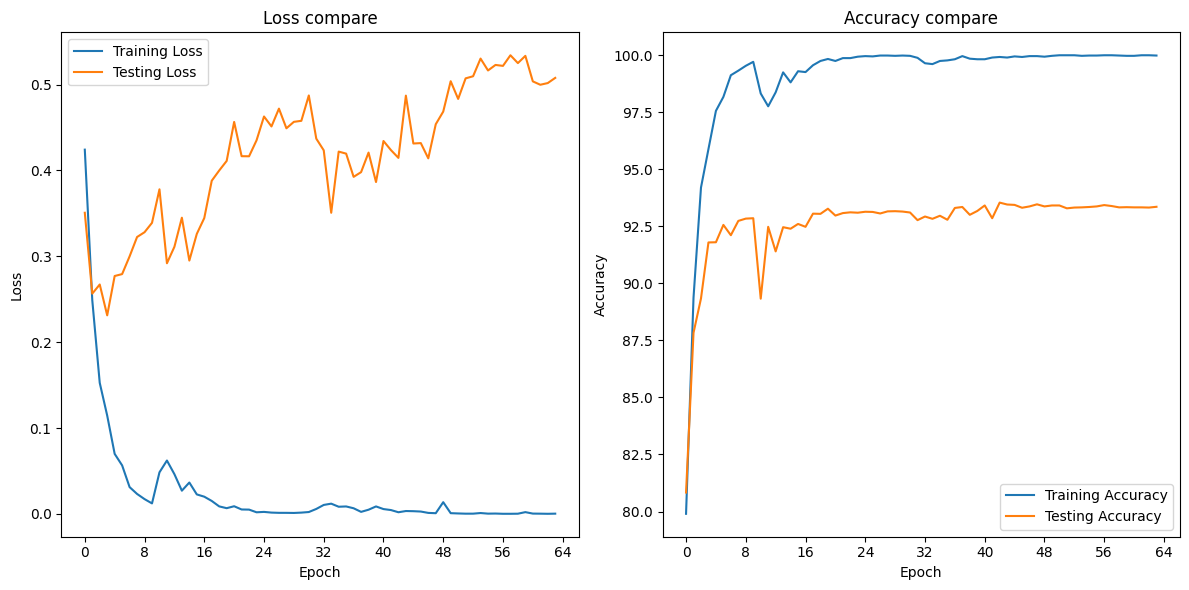

In [41]:
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import MaxNLocator



n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(np.arange(start, start+n_epochs,dtype=int), running_loss_list, label='Training Loss')
ax[0].plot(np.arange(start, start+n_epochs,dtype=int), testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

ax[1].plot(np.arange(start, start+n_epochs,dtype=int), running_accu_list, label='Training Accuracy')
ax[1].plot(np.arange(start, start+n_epochs,dtype=int), testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

plt.tight_layout()

figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
if os.path.isfile(figname):
  print(f"{figname} exist.")
else:
  plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'


#若是從checkpoint跑模型,把loss data接上去,loss data預設在模型參數資料夾下
if os.path.isfile(lossname):
  with open(lossname, 'r') as f:
    data_to_save = json.load(f)
  data_to_save['running_loss_list'].extend(running_loss_list)
  data_to_save['testing_loss_list'].extend(testing_loss_list)
  data_to_save['running_accu_list'].extend(running_accu_list)
  data_to_save['testing_accu_list'].extend(testing_accu_list)
else:
  data_to_save = {
      'running_loss_list': running_loss_list,
      'testing_loss_list': testing_loss_list,
      'running_accu_list': running_accu_list,
      'testing_accu_list': testing_accu_list
  }

with open(lossname, 'w') as f:
    json.dump(data_to_save, f, indent=4)

# 儲存模型參數



In [42]:
print(f'{model_name}_{epoch}')
print(f'{modeldirname}')

tf_efficientnetv2_s_64
tf_efficientnetv2_s_SGD_cosannealing


In [43]:

filename = save_model(model)


params = {
    'num_epochs': epoch,
    'batch_size': batch_size,
    'learning_rate': lr,
    'droprate': droprate
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

model will be saved as /content/drive/MyDrive/AOCR2024/params//
請輸入模型儲存的檔名:tf_efficientnetv2_s_SGD_cosannealing
請輸入模型儲存的資料夾:tf_efficientnetv2_s_64


# 讀取模型參數

In [ ]:
# model = pretrained_model
model = unet_model
print(model_name)

unet_without_decoder


In [ ]:
model = model.to(device)
model,_,params,_ = load_model(model)

請輸入模型參數檔案名稱:unet_without_decoder_40
請輸入儲存模型的母資料夾名稱:unet/unet_without_decoder_normalization
<All keys matched successfully>


# 單次評估


In [ ]:
# 評估設置
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)


valid_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.BCELoss()
valid_loss, valid_accuracy, predict_list = valid(valid_loader, model, criterion, 0.5, device)

print(f"Accuracy of the network on the test images: {valid_accuracy}%")
print(f"Loss: {valid_loss}")
predict_listq = predict_list.cpu()


Accuracy of the network on the 15592   
training images: 99.20472036942022%  
Loss: 0.03187363331013983


In [ ]:
print_results(predict_listq, labels[:len(predict_listq)])

# 測試

In [ ]:
testdir = "Cropped_60-316_150-406_11-71/Test_Image_cropped"

In [ ]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, testdir,token = credentials.token))

making Cropped_60-316_150-406_11-71/Test_Image_cropped dir...


100%|██████████| 200/200 [00:10<00:00, 18.34it/s]


In [ ]:
images_test, info = read_test(testdir,termi=200,shift=0)

In [ ]:
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)


# 對testing dataset做normalization
dataset = CustomDataset(images_test, None, mode='test', transform=transform_standard)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


batch_size:64
64


In [ ]:
model.eval()

predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    for j, batch_images in enumerate(dataloader):
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()

        # if predicted.dim() == 0:
        #   predicted = predicted.unsqueeze(0)
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()

In [ ]:
predict_listq.sum()

tensor(1100.)

# 輸出至提交格式

images讀進來是疊在一起的。 需要info紀錄images檔名順序與分割情況

In [ ]:
dflable = read_label(labelpath)

In [ ]:
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = dflable.index.str.match(pattern)
scan_guess = np.array(dflable[mask]['label'])

訓練過程不改變資料順序, 所以輸出順序同輸入.   
predict值跟隨images順序, 照著info把每個predict值(label)與檔名(id)對上. 輸出成提交格式

In [ ]:
def yes(predict):
  return int(sum(predict) >= 3)



predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
k = 0  #第幾個scan
ii = 0   #每個key輪到第幾個
id, nslice = info[k][0], info[k][1]
for i in range(len(predict_list)):

  if (ii >= nslice):
    #該換下一個scan了
    output[id] = yes(predict_list[i-nslice:i]) #評估方式

    k += 1
    ii = 0
    id, nslice = info[k][0], info[k][1]

  label = predict_list[i]
  output[id+f'_{ii}'] = int(predict_list[i])
  ii += 1

output[id] = yes(predict_list[(i+1)-ii:]) #補上最後一個scan評估
output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key)) #把母label移動到子label前面
filename = input("輸入提交路徑 (empty for submission\submission.csv)")
dfout.to_csv(os.path.join(drive_rootdir,'params','submission',filename)+'.csv', index=False)

輸入提交路徑 (empty for submission\submission.csv)unet_without_decoder_40


# 讀取提交格式的檔案

In [ ]:
dftest = read_submission('fisrt_80.csv')
# dftest = read_submission('submission.csv')
dflabel = read_label("TrainValid_ground_truth.csv")

In [ ]:
len(dftest)

In [ ]:
import re


# 抓出scan-level data
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = ~dftest.index.str.match(pattern)
scan_guess = np.array(dftest[mask]['label'])
scan_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

mask = ~mask
cut_guess = np.array(dftest[mask]['label'])
cut_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

In [ ]:
ss = 10
print("="*ss + "F1 score on scan level" + "="*ss)
print_results(scan_guess, scan_truth)
print(),print()
print("="*ss + "F1 score on cut level" +"="*ss )
print_results(cut_guess, cut_truth)

# 其他指令
不在工作流
臨時使用

**驗證數據集標準化**

In [ ]:
from torch.utils.data import DataLoader
import torch

def calculate_mean_std(dataset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    # 初始化总和和平方总和变量，以及样本数量
    total_sum = 0.0
    total_sq_sum = 0.0
    total_count = 0

    for data in dataloader:
        images, _ = data  # 假设每个数据是 (image, label) 格式

        # 将图像数据移至CPU并转换为一维
        images = images.view(images.size(0), -1)
        total_sum += images.sum(dim=1).sum(dim=0)
        total_sq_sum += (images ** 2).sum(dim=1).sum(dim=0)
        total_count += images.size(0) * images.size(1)

    # 计算总平均值和标准差
    mean = total_sum / total_count
    std = (total_sq_sum / total_count - mean ** 2) ** 0.5

    return mean, std




In [ ]:
import torch
# 獲取數據
images, labels = process_data2(datadir, termi=100, dropFalse=0)

In [ ]:

# 計算原始圖片mean
original_mean = torch.mean(images)
original_std = torch.std(images)
print(f'Original Mean: {original_mean}')
print(f'Original Std: {original_std}')

# 製作數據集
transform = transforms.Normalize(mean=original_mean, std=original_std)
dataset = CustomDataset(images, labels , transform=transform)
normalized_mean, normalized_std = calculate_mean_std(dataset)


# 输出
print(f'Normalized Mean: {normalized_mean}')
print(f'Normalized Std: {normalized_std}')



# # 計算原始圖片mean
# original_mean = torch.mean(images)
# original_std = torch.std(images)
# print(f'Original Mean: {original_mean}')
# print(f'Original Std: {original_std}')

# # 製作數據集
# transform = transforms.Normalize(mean=original_mean, std=original_std)
# dataset = CustomDataset(images, labels)

# normalized_images, normalized_labels = dataset[:]
# normalized_mean, normalized_std = torch.mean(normalized_images), torch.std(normalized_images)


# print(f'Normalized Mean: {normalized_mean}')
# print(f'Normalized Std: {normalized_std}')


Original Mean: -119.88312530517578
Original Std: 369.53607177734375
Normalized Mean: -5.324681584539803e-09
Normalized Std: 0.9999999403953552


**下載每個checkpoint的參數並validate**

In [ ]:
filelist = os.listdir('/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing')
current_folder = 'tf_efficientnetv2_s_SGD_cosannealing'

In [ ]:
# model = unet_model
model = pretrained_model

model = model.to(device)
print(model_name)

criterion = nn.BCELoss()

unet_without_decoder


In [ ]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images_validtrain, labels_validtrain =  process_data2(traindir=datadir,dropFalse=0,dropPos=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [ ]:
batch_size = 64
mean_train_, std_train_ = torch.mean(images_validtrain), torch.std(images_validtrain)
transform_train_ = transforms.Normalize(mean=mean_train_, std=std_train_)
validtrain_dataset = CustomDataset(images_validtrain, labels_validtrain, transform=transform_train_)
validtrain_loader = DataLoader(validtrain_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

valid_dataset = CustomDataset(images_valid, labels_valid, mode='valid', transform=transform_train_)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []

for current_model in filelist:
  model,_,params,_ = load_model(model, modelname=current_model.rstrip('.pth'),dirname=current_folder)


  epoch_loss, epoch_accuracy, predict_list_validtrain = valid(validtrain_loader, model, criterion, 0.5, device)
  valid_loss, valid_accuracy, predict_list = valid(valid_loader, model, criterion, 0.5, device)

  running_loss_list.append(epoch_loss)
  testing_loss_list.append(valid_loss)
  running_accu_list.append(epoch_accuracy)
  testing_accu_list.append(valid_accuracy)

  predict_listq = predict_list.cpu()
  predict_listq_validtrain = predict_list_validtrain.cpu()

  print(f"Accuracy of the {current_model} on the valid images: {valid_accuracy}%")
  print(f"Loss: {valid_loss}")
  print_results(predict_listq, labels_valid[:len(predict_listq)])


  print(f"Accuracy of the {current_model} on the validtrain images: {epoch_accuracy}%")
  print(f"Loss: {epoch_loss}")
  print_results(predict_listq_validtrain, labels_validtrain[:len(predict_listq_validtrain)])

<All keys matched successfully>


In [ ]:
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import MaxNLocator

savepath = "/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_cos/tf_efficientnetv2_s_400"
n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot( running_loss_list, label='Training Loss')
ax[0].plot( testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

ax[1].plot( running_accu_list, label='Training Accuracy')
ax[1].plot( testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

plt.tight_layout()

figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
if os.path.isfile(figname):
  print(f"{figname} exist.")
else:
  plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'


#若是從checkpoint跑模型,把loss data接上去,loss data預設在模型參數資料夾下
if os.path.isfile(lossname):
  with open(lossname, 'r') as f:
    data_to_save = json.load(f)
  data_to_save['running_loss_list'].extend(running_loss_list)
  data_to_save['testing_loss_list'].extend(testing_loss_list)
  data_to_save['running_accu_list'].extend(running_accu_list)
  data_to_save['testing_accu_list'].extend(testing_accu_list)
else:
  data_to_save = {
      'running_loss_list': running_loss_list,
      'testing_loss_list': testing_loss_list,
      'running_accu_list': running_accu_list,
      'testing_accu_list': testing_accu_list
  }

with open(lossname, 'w') as f:
    json.dump(data_to_save, f, indent=4)

drive檔案處理

重命名檔案

In [ ]:
cd /content/drive/MyDrive/AOCR2024/params

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params


In [ ]:
# %shell for file in tf_efficientnetv2_m*; do mv "$file" "${file/tf_efficientnetv2_m/unet}"; done